# Garmin Fit Files

- FIT files can be used to overlay a instrument gauges onto video feeds (see image below).
- Using a smart watch, a FIT file can be used to collect data about a race even if there are no instruments.

First a quick example of overlaying race log data onto a frame of a video file.

![im](Data/Images/virb_edit_screenshot.png)

Second a quick example of a track captured on a chartered boat in San Diego

![im](Data/Images/fit_watch_san_diego.png)

**Two goals**:  So there are two related, but ultimately independent goals, read and write.  

1. **Write**: take race log data and encode it as a FIT file.  If we can do this then we can use standard tools to create videos overlayed with synchronized gauge data.
1. **Read**: Consume a FIT file and convert it into race log data (pandas dataframe) for later analysis.

**Summary**: Reading works well, particularly for Garmin watch data.  Writing does not.  I tried for a very long time to create FIT files in the correct format for the video editing tool.  It is possible, but I decided to try another approach. There is a bunch of info below on how one might go about reading or writing the correct data, but it has not been completed.


## Background

FIT is a "standard" file format for transferring fitness info between devices.  It is closely tied to ANT, which I have seen mostly on bikes.  ANT, a radio standard, is the way devices like cadence sensors send info to bike computers.  Early on Garmin purchased the company that created FIT and ANT (Dynastream), and the standard remains *mostly* open (see [This Is Ant](https://www.thisisant.com/) for documents and code).  I believe Dynastream also "certifies" devices as compatible (or not).

I first encountered FIT when attempting to pull data from a Garmin watch.  If you go out on a new boat, or charter, a watch may be the only way to capture a race for later analysis.  I often use the RaceQs watch app, followed by downloading the FIT file from Garmin Connect.

The FIT file from my watch contains info from GPS (position and velocity), my heart rate, and a few other things.  The FIT file can be read using a Python library can `python-fitparse`.

Most Garmin devices produce FIT files, and this has led to a cool additional functionality: **you can overlay FIT data onto a video** (once again see image above).  This "dashboard" is created using a video editing tool from Garmin called [Virb Edit](https://buy.garmin.com/en-US/US/p/573412).  Virb is the brand name for Garmin cameras, and Virb Edit is used to edit video and produce final version.  Virb Edit can also be used to merge the video and the FIT data, producing awesome overlays.

Virb Edit calls FIT data "GMetrix" (for "Garmin Metrics"?).  There are a very wide range of "instrument" types.  And you can put together a pretty professional video.

Note, Virb Edit can be used with any video source (above is video from a GoPro).  

The fit file format is a mostly public standard, except for one **super annoying** gap: the marine data like that shown above (e.g. AWA, TWA, etc) is **not part of the standard** (more on that below).  This data actually came from a different Garmin boat (a J/99 called *One Life*).   Virb Edit can read this FIT file, and will overlay the encoded info on the video even though it is unrelated to my boat.  (Yes, this is useless, but it allowed me to verify that an external FIT file could be read and processed.)


## FIT file format

The FIT file format is defined in the [FIT SDK](https://www.thisisant.com/resources/fit-sdk-beta).  The SDK contains documentation and libraries and examples in C++, C#, and Java.  

FIT files are semi-structed, and consists of a list of messages.  The critical message types are "definition" and "data".  A definition message must proceed each type of data message.  The most common situation is where the definition message selects one of the pre-defined schemas and then sub-selects as set of fields.  Every data record of that type then must contain the fields specified in the definition.  The basic idea is that this is all very flexible, allowing the FIT file to be compact and dynamic.  

The global schema, which defines types and standard schemas, is stored in Profile.xlsx (yeah its annoying that its not JSON or XML).

There are many types of message schemas, from aviation to automotive.  The grandady of all messages is the "record" message (id 20), which is most likely used by most simple wearable devices to report sensor measurements.  The record message includes up to 120 fields like:

`position_lat, position_long, altitude, heart_rate, cadence, distance, speed, power, compressed_speed_distance, grade, resistance, time_from_course, cycle_length, temperature, speed_1s, cycles, total_cycles, compressed_accumulated_power, accumulated_power, left_right_balance, gps_accuracy, vertical_speed`

Other message types include: gps_metadata, gyroscope_data, and aviation_attitude.

Note, all of these message types and many more are available and can be used to encode data from the race.  But there are serious caveats:

- The fields must be supported by Virb Edit for them to show up as an overlay gauge.  This is a snall and **undocumented** subset of the full message set.
- The marine message type (message id 176) is **not defined in the FIT file documentation**.  I'm guessing that marine data must be considered propietary by Garmin.  This is not entirely different from the situation with NMEA, where competitors are strongly discouraged by putting up barriers to entry.

### Marine Data Disappointment

At first I thought I could simply use the same schema used by the Garmin Virb on *One Life*.  It gradually became apparent the sailing message is not documented.  For reference, the message is number 176.  It appears to have several fields, one of which is a binary blob:

```
{'unknown_253': 5862,
 'unknown_3': (197, 5, 0, 0, 12, 0, 0, 0, 1, 10, 3, 3, 136, 184, 3, 10, 188, 2, 17, 0, ...)
 'unknown_0': 13,
 'unknown_1': 0,
 'unknown_2': 1,
 'unknown_4': 20}
```

I am not sure why,  but for some reason I briefly considered reverse engineering this data. Heck this was done by the Canboat folks for NMEA 2k.  But it is just too hard, since I do not have a scheme for generating a wide range of input/output pairs.

A couple of observations, for posterity.  

- There are at least 9 channels in this record (I believe). 
  - TWA/TWS/AWA/TWA/SPD (these are not encoded elsewhere)
  - These are available, but may be encoded elsewhere Drift/SOG/COG/HDG (from GPS?)

- The crappy way to get an example input/output pairs is as follows:
  - Borrow a FIT file from One Life
  - Overlay the data on a random video (see image at top of this notebook).
  - Write down the GPS shown in the image.
  - Search through the FIT file for that GPS. Assume the alignment is good.  
  - In the image there are numeric values for instruments.
  - Reverse engineer!
  - Repeat?

- My guess is that these signals are encoded in a way that is similar to other signals (just a guess).
  - Need to determine the raw data type of each field (uint8, uint16, int8, int16 are the most likely).
  - Need to determine the byte position of each field.
  - Need determine the units, scale, and offset (e.g. altitude is scaled by 1/5 and then offset by 500). 
  - Kicker.  In theory the order of these fields is determined for each file by the "definition" record.  So it may all need to happen again.

### Spelunking 

Stuff I have tried and mostly failed.

- Grab a FIT file from *One Life* and then decode.  It just did not help much since the marine data is not documented.
- See if Dashware can load a fit file (it did not for me).
- Try to explore how FlightData Manager works (I have run it under windows, but don't have a PUD file, which may be JSON by the way).

Complexities

- It appears that FIT timestamps are forced to be in units of seconds!  
  - There appears to be an ability to encode multiple measurement in a single message (barometer does this... though not sure why).  You provide an array of msec offsets and an array of data.
  - Perhaps 1 message a second is enough?
  
### Garmin Virb 306 info

For posterity.  

- The Garmin Virb 360 camera captures videos in blocks (much like a GoPro).  The blocks are 30 mins long (and about 18 GB).
- There is often a single FIT file for the entire set of videos.  I have found this both to be true for a continuous recording **and** when I recorded two videos in close succession (a minute apart).


## Reading FIT Files

### Using python-fitparse

For these example we will use FIT files collected from a Garmin Vivoactive 3 while sailing in San Diego on a chartered boath.

There is a well done python library that parses fit files...  at least those that subscribe to the standard [python-fitparse](https://github.com/dtcooper/python-fitparse).  The implementation is easy to use and fairly complete.

In [1]:
# Load some libraries
%matplotlib notebook
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

import itertools as it
import pandas as pd
import numpy as np

# These are libraries written for RaceAnalysis
import global_variables
# We are using San Diego for these examples!
# G = global_variables.init_seattle()
G = global_variables.init_san_diego()
import race_logs
import process as p
import analysis as a
import chart as c

# This is the python-fitparse library
from fitparse import FitFile

In [2]:
ff = FitFile('Data/GarminWatchFit/4324683973.fit')

messages = list(it.islice(ff.get_messages(), 0, 4, None))

for m in messages:
    print(repr(m))
    print()

<DataMessage: file_id (#0) -- local mesg: #0, fields: [serial_number: 3990288872, time_created: 2019-12-09 19:36:03, unknown_7: None, manufacturer: garmin, garmin_product: 2988, number: None, type: activity]>

<DataMessage: file_creator (#49) -- local mesg: #1, fields: [unknown_2: None, software_version: 540, hardware_version: None]>

<DataMessage: event (#21) -- local mesg: #2, fields: [timestamp: 2019-12-09 19:36:03, timer_trigger: manual, event: timer, event_type: start, event_group: 0, unknown_19: None, unknown_20: None]>

<DataMessage: device_info (#23) -- local mesg: #3, fields: [timestamp: 2019-12-09 19:36:03, serial_number: 3990288872, cum_operating_time: None, unknown_8: None, unknown_15: None, unknown_16: None, unknown_17: None, unknown_24: None, unknown_31: None, manufacturer: garmin, garmin_product: 2988, software_version: 5.4, battery_voltage: None, unknown_13: None, ant_device_number: None, device_index: creator, device_type: None, hardware_version: None, unknown_9: None,

### Perhaps a bit too "processed"?

I am actually super impressed with `python-fitparse`, hiding behind this nice interface to the data messages is a lot of work.  The library can read and process the `profile.xlsx` and automatically generate python code for reading messages.  It handles parsing of the bits in the messages, and conversion of units.  It hides the annoyance of "defintion" messages (which do not contain data) and gets you straight to parsed "data" messages.

My only real criticism of python-fitparse is that it **cannot write FIT files**.  Since we will need to write FIT files, it will make sense to dig deeper into the FIT file format.

In [3]:
# For each data message, the definition message is available.
messages[0].def_mesg

<DefinitionMessage: file_id (#0) -- local mesg: #0, field defs: [serial_number, time_created, unknown_7, manufacturer, product, number, type], dev field defs: []>

### Looking at the CSV file

The FIT file is binary. FIT_SDK provides a tool to convert it to a CSV, which is close to "raw" but human readable.

Here is the first few lines of `4324683973.csv`.  I have added linebreaks for clarity.

```
Definition,0,file_id,serial_number,1,,time_created,1,,unknown,1,,manufacturer,1,,product,1,,number,1,,type,1,,
Data,0,file_id,serial_number,"3990288872",,time_created,"944854563",,unknown,"4294967295",,manufacturer,"1",,garmin_product,"2988",,number,"65535",,type,"4",,

Definition,1,file_creator,unknown,20,,software_version,1,,hardware_version,1,,,,,,,,,,,,,,
Data,1,file_creator,software_version,"540",,hardware_version,"255",,,,,,,,,,,,,,,,,

Definition,2,event,timestamp,1,,data,1,,event,1,,event_type,1,,event_group,1,,unknown,1,,unknown,1,,
Data,2,event,timestamp,"944854563",s,timer_trigger,"0",,event,"0",,event_type,"0",,event_group,"0",,unknown,"255",,unknown,"255",,

Definition,3,device_info,timestamp,1,,serial_number,1,,cum_operating_time,1,,unknown,1,,unknown,1,,unknown,1,,unknown,32,,unknown,1,,unknown,1,,manufacturer,1,,product,1,,software_version,1,,battery_voltage,1,,unknown,1,,ant_device_number,1,,device_index,1,,device_type,1,,hardware_version,1,,unknown,1,,battery_status,1,,ant_transmission_type,1,,ant_network,1,,unknown,1,,source_type,1,,unknown,6,,unknown,1,,

Data,3,device_info,timestamp,"944854563",s,serial_number,"3990288872",,cum_operating_time,"4294967295",s,unknown,"4294967295",,unknown,"4294967295",,unknown,"4294967295",,unknown,"0",,unknown,"4294967295",,manufacturer,"1",,garmin_product,"2988",,software_version,"5.4",,battery_voltage,"65535",V,unknown,"65535",,ant_device_number,"0",,device_index,"0",,device_type,"255",,hardware_version,"255",,unknown,"255",,battery_status,"255",,ant_transmission_type,"0",,ant_network,"255",,unknown,"255",,source_type,"5",,unknown,"255|255|255|255|255|255",,unknown,"255",,,,,

Data,3,device_info,timestamp,"944854563",s,serial_number,"0",,cum_operating_time,"4294967295",s,unknown,"4294967295",,unknown,"4294967295",,unknown,"4294967295",,unknown,"0",,unknown,"4294967295",,manufacturer,"1",,garmin_product,"2988",,software_version,"5.4",,battery_voltage,"65535",V,unknown,"65535",,ant_device_number,"0",,device_index,"1",,device_type,"4",,hardware_version,"255",,unknown,"255",,battery_status,"255",,ant_transmission_type,"0",,ant_network,"255",,unknown,"255",,source_type,"5",,unknown,"255|255|255|255|255|255",,unknown,"255",,,,,
```

Note: 
- There are many places where `unknown` appears.  These are all places where the file does not obey the standard.  This file came from my Garmin Vivoactive 3...  there is no excuse for this! And it is worrisome.
- There are a number of commas at the end of each line.  It is an artifact of the CSV format.  All lines must have the same number of commas (I'll delete them below).

The first 3 blocks make sense.  They are definitions followed by data rows.  There is lots of info in this file which seems esoteric (including my weight and height in later rows).

The 97% of this file is all about the **record** message (message number 20).  

```
Definition,12,record,timestamp,1,,position_lat,1,,position_long,1,,distance,1,,altitude,1,,speed,1,,unknown,1,,unknown,1,,heart_rate,1,,cadence,1,,fractional_cadence,1,,

Data,12,record,timestamp,"944854563",s,position_lat,"390369713",semicircles,position_long,"-1398518623",semicircles,distance,"0.0",m,altitude,"9.0",m,speed,"2.286",m/s,unknown,"0",,unknown,"100",,heart_rate,"99",bpm,cadence,"0",rpm,fractional_cadence,"0.0",rpm,enhanced_altitude,"9.0",m,enhanced_speed,"2.286",m/s,

Data,12,record,timestamp,"944854578",s,position_lat,"390371106",semicircles,position_long,"-1398514720",semicircles,distance,"33.28",m,altitude,"8.800000000000011",m,speed,"2.183",m/s,unknown,"0",,unknown,"100",,heart_rate,"95",bpm,cadence,"0",rpm,fractional_cadence,"0.0",rpm,enhanced_altitude,"8.800000000000011",m,enhanced_speed,"2.183",m/s,,
```

Returning to fitparse.

In [4]:
# Let's only look at the records
messages = list(it.islice(ff.get_messages('record'), 0, 2, None))

for m in messages:
    print(repr(m))
    print()

<DataMessage: record (#20) -- local mesg: #12, fields: [timestamp: 2019-12-09 19:36:03, position_lat: 390369713, position_long: -1398518623, distance: 0.0, enhanced_altitude: 9.0, altitude: 2545, enhanced_speed: 2.286, speed: 2286, unknown_87: 0, unknown_88: 100, heart_rate: 99, cadence: 0, fractional_cadence: 0.0]>

<DataMessage: record (#20) -- local mesg: #12, fields: [timestamp: 2019-12-09 19:36:18, position_lat: 390371106, position_long: -1398514720, distance: 33.28, enhanced_altitude: 8.800000000000011, altitude: 2544, enhanced_speed: 2.183, speed: 2183, unknown_87: 0, unknown_88: 100, heart_rate: 95, cadence: 0, fractional_cadence: 0.0]>



### Obscurities

Altitude and speed seem to be represented twice... but they are the same bits interpretted in two ways.  Altitude/speed are the two fields.  enhanced_altitude and enhanced_speed are components of those fields, which specify a scale and offset.  

In [5]:
altitude = 2545
speed = 2286

print(altitude/5 - 500)
print(speed/1000)

9.0
2.286


In [6]:
# FIT packs lat and long into signed 16 bits ints.  The unit is called the "semi-circle"
SEMICIRCLES_TO_DEGREES = 180/2**31

def semi_to_degrees(semicircles):
    "Convert the Garmin unit called semicircle to degrees."
    return SEMICIRCLES_TO_DEGREES * semicircles

def fitfile_to_pandas(fitfile):
    rows = []
    # Get all data messages that are of type record
    for record in it.islice(fitfile.get_messages('record'), 0, None, None):
        # Go through all the data entries in this record
        row = {}
        for record_data in record:
            # Print the records name and value (and units if it has any)
            if record_data.units:
                name = record_data.name + "_" + record_data.units
            else:
                name = record_data.name
            row[name] = record_data.value
        rows.append(row)
    df = pd.DataFrame(rows)
    df = df[df.isna().sum(1) == 0]
    df['longitude'] = semi_to_degrees(df.position_long_semicircles)
    df['latitude'] = semi_to_degrees(df.position_lat_semicircles)
    df['row_times'] = df.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Pacific')
    return df

df = fitfile_to_pandas(ff)
print(df.columns)
df.iloc[:5]

Index(['altitude', 'cadence_rpm', 'distance_m', 'enhanced_altitude_m',
       'enhanced_speed_m/s', 'fractional_cadence_rpm', 'heart_rate_bpm',
       'position_lat_semicircles', 'position_long_semicircles', 'speed',
       'timestamp', 'unknown_87', 'unknown_88', 'longitude', 'latitude',
       'row_times'],
      dtype='object')


,altitude,cadence_rpm,distance_m,enhanced_altitude_m,enhanced_speed_m/s,fractional_cadence_rpm,heart_rate_bpm,position_lat_semicircles,position_long_semicircles,speed,timestamp,unknown_87,unknown_88,longitude,latitude,row_times
0,2545,0,0.000,9.000,2.286,0.000,99.000,390369713.000,-1398518623.000,2286.000,2019-12-09 19:36:03,0,100.000,-117.222,32.720,2019-12-09 11:36:03-08:00
1,2544,0,33.280,8.800,2.183,0.000,95.000,390371106.000,-1398514720.000,2183.000,2019-12-09 19:36:18,0,100.000,-117.222,32.721,2019-12-09 11:36:18-08:00
2,2546,0,44.100,9.200,2.267,0.000,98.000,390371641.000,-1398513499.000,2267.000,2019-12-09 19:36:23,0,100.000,-117.222,32.721,2019-12-09 11:36:23-08:00
3,2546,0,48.300,9.200,2.221,0.000,95.000,390371811.000,-1398513005.000,2221.000,2019-12-09 19:36:25,0,100.000,-117.222,32.721,2019-12-09 11:36:25-08:00
4,2545,0,61.680,9.000,2.407,0.000,95.000,390372244.000,-1398511376.000,2407.000,2019-12-09 19:36:31,0,100.000,-117.222,32.721,2019-12-09 11:36:31-08:00


<IPython.core.display.Javascript object>


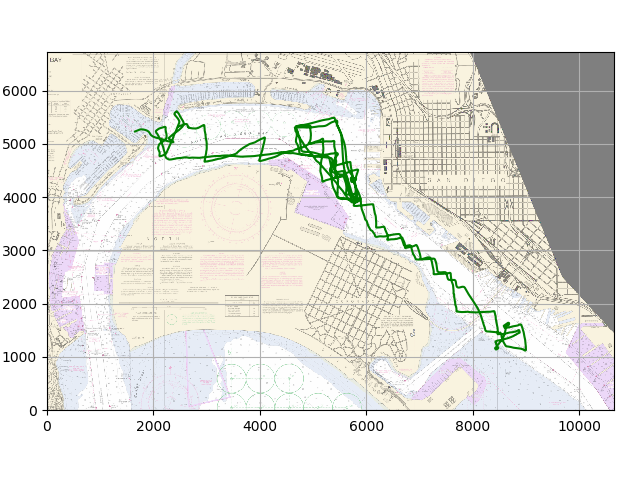

In [7]:
ch = c.plot_chart(df)
c.draw_track(df, ch)